In [3]:
# !pip install --upgrade diffusers

In [3]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from IPython import display

## diffusers

- pipeline
    - `StableDiffusionPipeline`
        - generate samples 
        - 参数
            - `guidance_scale`, which determines how much the model will try to match the prompt.
    - `DDPMPipeline`
- Models
    - `UNet` => `DiT`
- Schedulers
    - DDPMScheduler (https://arxiv.org/abs/2006.11239)

In [4]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### StableDiffusionPipeline

In [32]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

[2024-02-29 20:47:30,388] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [33]:
pipe.components.keys()

dict_keys(['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder'])

In [34]:
pipe??

In [18]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
images = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, num_images_per_prompt=5).images

  0%|          | 0/50 [00:00<?, ?it/s]

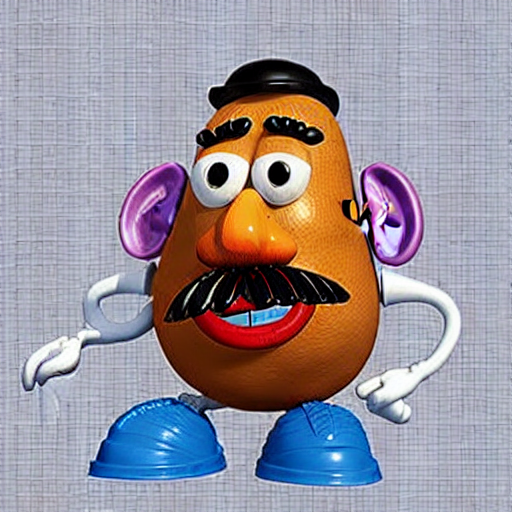

In [23]:
images[2]

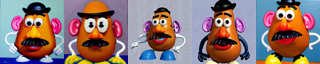

In [19]:
make_grid(images)

### DDPMPipeline

In [25]:
butterfly_pipeline??

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

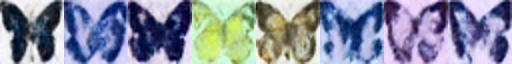

In [35]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

In [36]:
butterfly_pipeline.components.keys()

dict_keys(['unet', 'scheduler'])

## images dataset

In [19]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        # (0, 1) - 0.5 => [-0.5, 0.5]
        # [-0.5, 0.5] / 0.5 => [-1, 1]
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

/home/whaow/anaconda3/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [20]:
next(iter(train_dataloader))['images'].shape

torch.Size([64, 3, 32, 32])

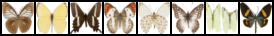

In [21]:
image_batch = next(iter(train_dataloader))['images'].to(device)[:8]
show_images(image_batch)

In [86]:
len(train_dataloader)

16

In [87]:
len(train_dataloader.dataset)

1000

In [90]:
1000/64

15.625

## Scheduler

- forward noising process (pixel space):

    $$
    \begin{split}
    &q(x_t|x_{t-1})\sim \mathcal N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t\mathbb I)\\
    &q(x_{1:T}|x_0)=\Pi_{t=1}^Tq(x_t|x_{t-1})\\
    &q(x_t|x_0)=\mathcal N(x_t;\sqrt{\bar \alpha_t}x_0,(1-\bar\alpha_t)I), \quad \alpha_i=1-\beta_i,\bar\alpha_t=\Pi_{i=1}^T\alpha_i
    \end{split}
    $$
    
    - **scale** $x_{t-1}$ by $\sqrt{1-\beta_t}$ and **add noise scaled by** $\beta_t$
    - 对比 VaE（为什么叫 diffusion 而不是一种 VAE, latent space）
        - Encoder：$q(z|x)$, $x_0\rightarrow z_T$
        - Decoder: $p(x|z)$, $z_T\rightarrow x_0$
    

In [4]:
from diffusers import DDPMScheduler

In [5]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [7]:
noise_scheduler.config.beta_schedule, noise_scheduler.config.beta_start, noise_scheduler.config.beta_end

('linear', 0.0001, 0.02)

In [15]:
torch.allclose(1- torch.linspace(0.0001, 0.02, 1000), noise_scheduler.alphas)

True

In [12]:
torch.allclose(torch.cumprod(noise_scheduler.alphas, 0), noise_scheduler.alphas_cumprod)

True

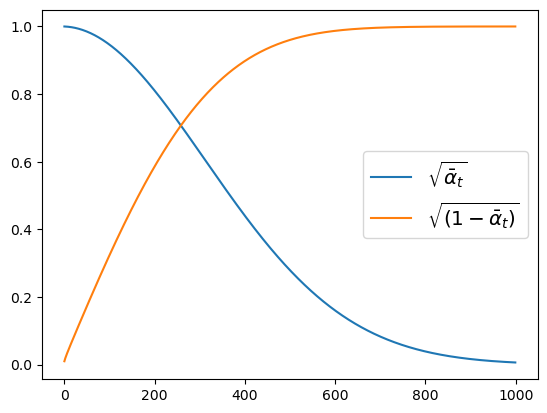

In [16]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

- $\bar\alpha_1, \bar\alpha_2, \bar\alpha_3, ..., \bar\alpha_t$：是逐渐变小的过程

In [17]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [24]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

In [26]:
noise = torch.randn_like(image_batch)
noise.shape

torch.Size([8, 3, 32, 32])

In [29]:
# noise_scheduler.add_noise??

In [27]:
noisy_image_batch = noise_scheduler.add_noise(image_batch, noise, timesteps)

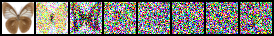

In [30]:
show_images(noisy_image_batch)

## UNet (denoising model)

- U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/abs/1505.04597
- downsample: ResNet blocks
- #downsamples == #upsamples
    - down_block_types
    - up_block_types
- skip connection linking features of (downsample / upsample)
- output size == input size

In [15]:
display.Image(url='https://i.imgur.com/S7KH5hZ.png', width=600)

$$
\epsilon_\theta(x_t, t)
$$

- unet denoising model
    - input: $(x_t, t)$
    - output 是添加在 $x_t$ 上的 noise；

In [43]:
display.Image(url='https://camo.githubusercontent.com/2c676413dda1f487521dd5c1e5c4b35b8cfbf06d50880e15660ea44bd76eac6f/68747470733a2f2f68756767696e67666163652e636f2f64617461736574732f68756767696e67666163652f646f63756d656e746174696f6e2d696d616765732f7265736f6c76652f6d61696e2f756e65742d6d6f64656c2e706e67', 
              width=600)

In [1]:
from diffusers import UNet2DModel

[2024-03-01 21:15:05,518] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [6]:
image_size = 32

In [7]:
unet = UNet2DModel(sample_size=image_size, 
                   in_channels=3, 
                   out_channels=3, 
                   layers_per_block=2, 
                   block_out_channels=[64, 128, 128, 256], 
                   down_block_types=['DownBlock2D', 'DownBlock2D', # a regular ResNet downsampling block
                                     'AttnDownBlock2D', # a ResNet downsampling block with spatial self-attention
                                     'AttnDownBlock2D'], 
                   up_block_types=['AttnUpBlock2D', 'AttnUpBlock2D', # a ResNet upsampling block with spatial self-attention
                                   'UpBlock2D', 'UpBlock2D', # a regular ResNet upsampling block
                                  ])
unet = unet.to(device)
# unet

In [12]:
unet.forward??

In [77]:
# (image, t)
with torch.no_grad():
    model_pred = unet(noisy_image_batch, timesteps).sample
model_pred.shape

torch.Size([8, 3, 32, 32])

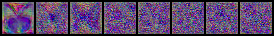

In [78]:
show_images(model_pred)

## training

In [80]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(unet.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/home/whaow/anaconda3/lib/python3.10/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.14915950456634164
Epoch:10, loss: 0.11450566304847598
Epoch:15, loss: 0.10151417413726449
Epoch:20, loss: 0.09067434864118695
Epoch:25, loss: 0.07668635924346745
Epoch:30, loss: 0.07491934159770608


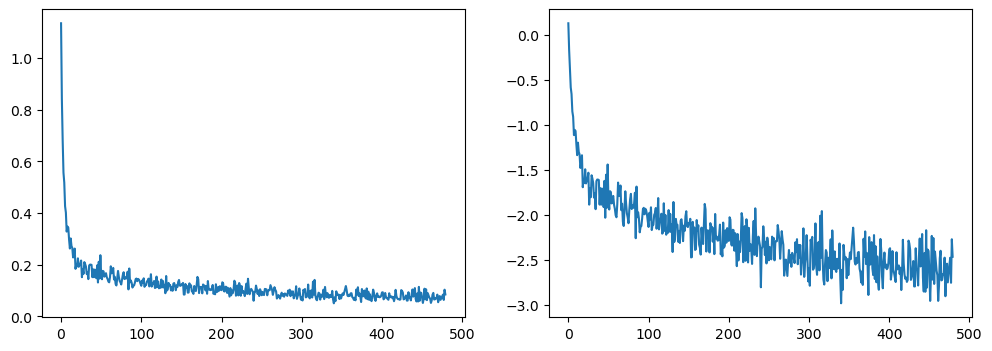

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[1].plot(np.log(losses))